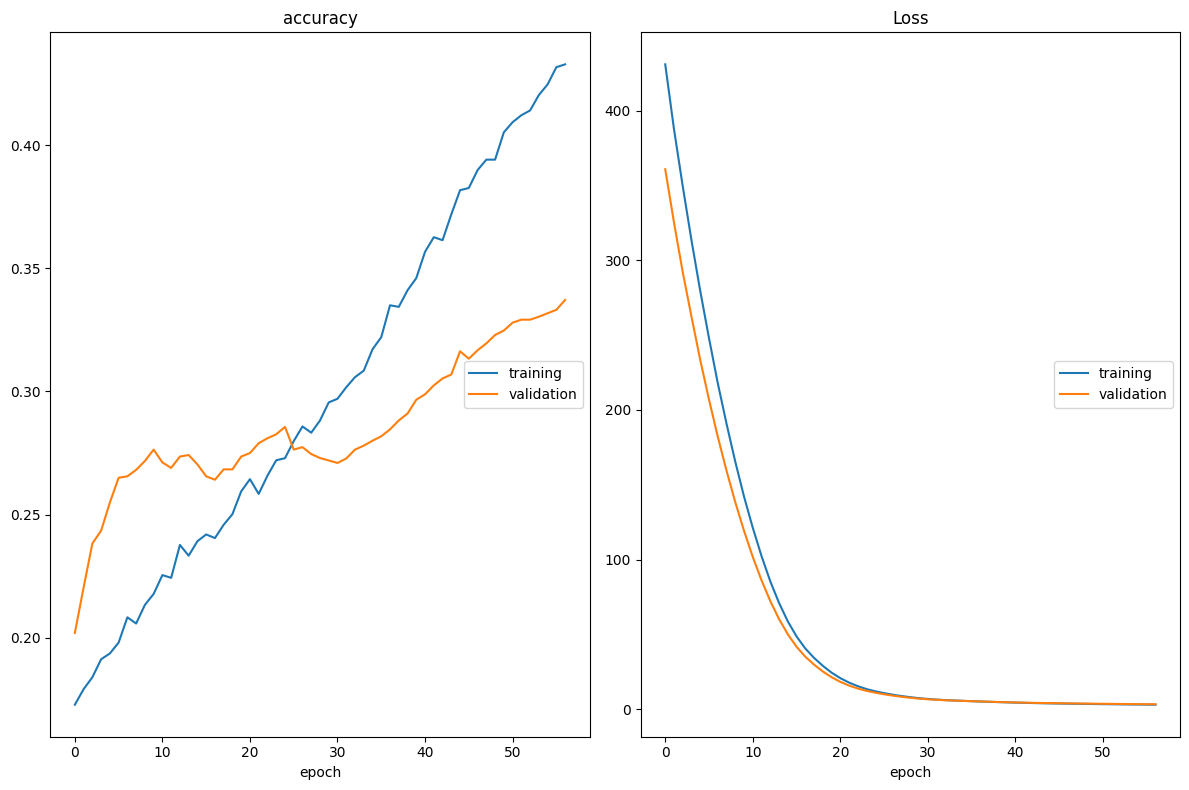

accuracy
	training         	 (min:    0.173, max:    0.433, cur:    0.433)
	validation       	 (min:    0.202, max:    0.337, cur:    0.337)
Loss
	training         	 (min:    3.067, max:  430.916, cur:    3.067)
	validation       	 (min:    3.348, max:  360.840, cur:    3.348)
595/595 [==============================] - 12s 21ms/step - loss: 3.0669 - accuracy: 0.4328 - val_loss: 3.3478 - val_accuracy: 0.3371
Epoch 58/400
593/595 [============================>.] - ETA: 0s - loss: 3.0138 - accuracy: 0.4383

In [ ]:
# скачивание всего проекта
!wget https://github.com/gimaevra94/emotions_detector/archive/refs/heads/main.zip

# распаковка проекта
!unzip /content/main.zip

# распаковка самих данных
!unzip /content/emotions_detector-main/data/data_6_831_3171.zip

!pip install livelossplot

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

from pathlib import Path
from livelossplot import PlotLossesKeras

# дропаут шаг и регулярицация вынесены сюда для тестов
drop=0.45
rg=L1L2(0.45)
lr=0.00001

# создание каталогов под классы
path='/content/data_6_831_3171'

base_dir=Path(path).parent/'data_6_831_3171'
train_dir=base_dir/'train'
test_dir=base_dir/'test'

anger_dir=train_dir/'anger'
fear_dir=train_dir/'fear'
happy_dir=train_dir/'happy'
neutral_dir=train_dir/'neutral'
sad_dir=train_dir/'sad'
surprise_dir=train_dir/'surprise'

anger_dir=test_dir/'anger'
fear_dir=test_dir/'fear'
happy_dir=test_dir/'happy'
neutral_dir=test_dir/'neutral'
sad_dir=test_dir/'sad'
surprise_dir=test_dir/'surprise'

# изображения становятся одноканальными 48х48 с сохранением пропорций и перемешиваются
train = image_dataset_from_directory(directory=train_dir,
                                     label_mode='int',
                                     color_mode='grayscale',
                                     image_size=(48, 48),
                                     crop_to_aspect_ratio=True,
                                     shuffle=True)

test = image_dataset_from_directory(directory=test_dir,
                                    label_mode='int',
                                    color_mode='grayscale',
                                    image_size=(48, 48),
                                    crop_to_aspect_ratio=True,
                                    shuffle=True)

# я следовал архитектуре u-net
inp=Input((48,48,1))

norm_0=Normalization()(inp)

# понижение размерности признакового пространсва
# свертки со страйдом вместо макспулинга
conv_0=Conv2D(4,3,padding='same',activation='relu', kernel_regularizer=rg)(norm_0)
conv_str_0=Conv2D(1,3,2,padding='same',activation= 'relu', kernel_regularizer=rg)(conv_0)
conv_1=Conv2D(8,3,padding='same',activation='relu', kernel_regularizer=rg)(conv_str_0)
conv_str_1=Conv2D(1,3,2,padding='same',activation= 'relu', kernel_regularizer=rg)(conv_1)
conv_2=Conv2D(16,3,padding='same',activation='relu', kernel_regularizer=rg)(conv_str_1)
conv_str_2=Conv2D(1,3,2,padding='same',activation= 'relu', kernel_regularizer=rg)(conv_2)

drop_0=Dropout(drop)(conv_str_2)
norm_1=Normalization()(drop_0)

# дилатационные свертки
dila_0=Conv2D(16,3,padding='same',activation='relu',dilation_rate=6, kernel_regularizer=rg)(norm_1)
dila_1=Conv2D(16,3,padding='same',activation='relu',dilation_rate=12, kernel_regularizer=rg)(norm_1)
dila_2=Conv2D(16,3,padding='same',activation='relu',dilation_rate=18, kernel_regularizer=rg)(norm_1)

# склейка и перемешивание дилатационных сверток
concat_0=Concatenate()([dila_0, dila_1, dila_2])
conv_1x1_0=Conv2D(16,3,padding='same',activation='relu', kernel_regularizer=rg)(concat_0)

drop_1=Dropout(drop)(conv_1x1_0)
norm_2=Normalization()(drop_1)

# повышение размерности признакового пространсва и проброс инфы с более ранних слоев
trans_0=Conv2DTranspose(16,3,2,padding='same',activation='relu', kernel_regularizer=rg)(norm_2)
concat_1=Concatenate()([conv_2, trans_0])
trans_1=Conv2DTranspose(8,3,2,padding='same',activation='relu', kernel_regularizer=rg)(concat_1)
concat_2=Concatenate()([conv_1, trans_1])
trans_2=Conv2DTranspose(4,3,2,padding='same',activation='relu', kernel_regularizer=rg)(concat_2)
concat_3=Concatenate()([conv_0, trans_2])

drop_2=Dropout(drop)(concat_3)
norm_3=Normalization()(drop_2)

flat=Flatten()(norm_3)
out=Dense(7,activation='softmax')(flat)

model=Model(inputs=inp,outputs=out)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=lr),
    metrics='accuracy')

# коллбек ловит val_loss на <=15%, останавливает сеть и сохраняет в файл
class MyCallback(Callback):
    def on_epoch_end(self,epoch,logs=None):
        val_loss=logs["val_loss"]
        if val_loss<=0.1500:
            self.model.stop_training=True
            self.model.save('model.h5')

history=model.fit(x=train,
                    epochs=400,
                    validation_data=test,
                    # PlotLossesKeras() рисует график после каждой эпохи
                    callbacks=[PlotLossesKeras(),MyCallback()])